<a href="https://colab.research.google.com/github/adap7/IRTM/blob/main/IRTM_Tutorial_query_2024_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining
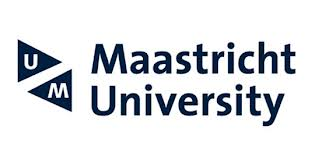
## Notebook 3

Version 2024-2025

Adapted and updated from [here](https://github.com/castorini/anserini-notebooks-afirm2020)

# Indexing


We start by reindexing the dataset as we did in the previous notebook so we can query it:

In [1]:
!git clone https://github.com/castorini/anserini.git
!cd anserini && git checkout ad5ba1c76196436f8a0e28efdb69960d4873efe3

Cloning into 'anserini'...
remote: Enumerating objects: 48280, done.
remote: Counting objects: 100% (1337/1337), done.
remote: Compressing objects: 100% (452/452), done.
remote: Total 48280 (delta 1160), reused 912 (delta 874), pack-reused 46943 (from 2)
Receiving objects: 100% (48280/48280), 93.81 MiB | 10.39 MiB/s, done.
Resolving deltas: 100% (36824/36824), done.
Note: switching to 'ad5ba1c76196436f8a0e28efdb69960d4873efe3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ad5ba1c7 Release notes for v0.9.2 (#

In [2]:
!apt-get install -y openjdk-11-jdk-headless
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.26+4-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
env: JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64


In [3]:
!apt-get install -q maven

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libaopalliance-java libapache-pom-java libatinject-jsr330-api-java
  libcdi-api-java libcommons-cli-java libcommons-io-java libcommons-lang3-java
  libcommons-parent-java libgeronimo-annotation-1.3-spec-java
  libgeronimo-interceptor-3.0-spec-java libguava-java libguice-java
  libhawtjni-runtime-java libjansi-java libjansi-native-java libjsr305-java
  libmaven-parent-java libmaven-resolver-java libmaven-shared-utils-java
  libmaven3-core-java libplexus-cipher-java libplexus-classworlds-java
  libplexus-component-annotations-java libplexus-interpolation-java
  libplexus-sec-dispatcher-java libplexus-utils2-java libsisu-inject-java
  libsisu-plexus-java libslf4j-java libwagon-file-java
  libwagon-http-shaded-java libwagon-provider-api-java
Suggested packages:
  libaopalliance-java-doc libatinject-jsr330-api-java-doc libel-api-java
  libcommons-io-java-d

In [4]:
!cd anserini && mvn clean package appassembler:assemble | grep "BUILD"

[INFO] BUILD SUCCESS


In [5]:
!mkdir -p data
!wget https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
!tar -xvf collectionandqueries.tar.gz -C data

--2025-04-12 09:44:32--  https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
Resolving msmarco.z22.web.core.windows.net (msmarco.z22.web.core.windows.net)... 20.150.34.1
Connecting to msmarco.z22.web.core.windows.net (msmarco.z22.web.core.windows.net)|20.150.34.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1057717952 (1009M) [application/gzip]
Saving to: ‘collectionandqueries.tar.gz’

collectionandquerie 100%[===================>]   1009M  15.5MB/s    in 81s     

2025-04-12 09:45:54 (12.4 MB/s) - ‘collectionandqueries.tar.gz’ saved [1057717952/1057717952]

collection.tsv
qrels.dev.small.tsv
qrels.train.tsv
queries.dev.small.tsv
queries.dev.tsv
queries.eval.small.tsv
queries.eval.tsv
queries.train.tsv


In [6]:
!cd anserini && python ./src/main/python/msmarco/convert_collection_to_jsonl.py \
 --collection_path ../data/collection.tsv --output_folder ../data/collection_jsonl

Converting collection...
Converted 0 docs in 1 files
Converted 100000 docs in 1 files
Converted 200000 docs in 1 files
Converted 300000 docs in 1 files
Converted 400000 docs in 1 files
Converted 500000 docs in 1 files
Converted 600000 docs in 1 files
Converted 700000 docs in 1 files
Converted 800000 docs in 1 files
Converted 900000 docs in 1 files
Converted 1000000 docs in 2 files
Converted 1100000 docs in 2 files
Converted 1200000 docs in 2 files
Converted 1300000 docs in 2 files
Converted 1400000 docs in 2 files
Converted 1500000 docs in 2 files
Converted 1600000 docs in 2 files
Converted 1700000 docs in 2 files
Converted 1800000 docs in 2 files
Converted 1900000 docs in 2 files
Converted 2000000 docs in 3 files
Converted 2100000 docs in 3 files
Converted 2200000 docs in 3 files
Converted 2300000 docs in 3 files
Converted 2400000 docs in 3 files
Converted 2500000 docs in 3 files
Converted 2600000 docs in 3 files
Converted 2700000 docs in 3 files
Converted 2800000 docs in 3 files
Conv

In [7]:
!cd anserini && sh target/appassembler/bin/IndexCollection -collection JsonCollection -input ../data/collection_jsonl \
 -index ../indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs -generator DefaultLuceneDocumentGenerator -threads 9 \
 -storePositions -storeDocvectors -storeRaw

2025-04-12 09:47:51,596 INFO  [main] index.IndexCollection (IndexCollection.java:636) - Setting log level to INFO
2025-04-12 09:47:51,600 INFO  [main] index.IndexCollection (IndexCollection.java:639) - Starting indexer...
2025-04-12 09:47:51,600 INFO  [main] index.IndexCollection (IndexCollection.java:640) - ============ Loading Parameters ============
2025-04-12 09:47:51,601 INFO  [main] index.IndexCollection (IndexCollection.java:641) - DocumentCollection path: ../data/collection_jsonl
2025-04-12 09:47:51,602 INFO  [main] index.IndexCollection (IndexCollection.java:642) - CollectionClass: JsonCollection
2025-04-12 09:47:51,602 INFO  [main] index.IndexCollection (IndexCollection.java:643) - Generator: DefaultLuceneDocumentGenerator
2025-04-12 09:47:51,603 INFO  [main] index.IndexCollection (IndexCollection.java:644) - Threads: 9
2025-04-12 09:47:51,604 INFO  [main] index.IndexCollection (IndexCollection.java:645) - Stemmer: porter
2025-04-12 09:47:51,604 INFO  [main] index.IndexCollec

# Querying

In this exercise, we are going to first interactively query the index and then produce a TREC run with [Pyserini](https://github.com/castorini/pyserini), the Python interface to Anserini.

## Setup

Install Python dependencies (again - remember that each notebook instantiates a virtual machine of its own):

In [8]:
!pip install pyjnius==1.2.1
!pip install pyserini==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyjnius
  Running setup.py clean for pyjnius
Failed to build pyjnius
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyjnius)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00


Instead of building anserini from scratch, we download the fatjar from the maven repository and store it locally:

In [9]:
!wget -O anserini-0.9.2-fatjar.jar https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar

--2025-04-12 10:03:13--  https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar
Resolving search.maven.org (search.maven.org)... 54.243.149.110, 54.164.97.135
Connecting to search.maven.org (search.maven.org)|54.243.149.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://repo1.maven.org/maven2/io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar [following]
--2025-04-12 10:03:13--  https://repo1.maven.org/maven2/io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62703127 (60M) [application/java-archive]
Saving to: ‘anserini-0.9.2-fatjar.jar’

anserini-0.9.2-fatj 100%[===================>]  59.80M   170MB/s    in 0.4s    

2025-04-12 10:03:14 (170 MB/s

Let's point Pyserini to the Anserini jar that we have just installed:

In [10]:
import os
os.environ['ANSERINI_CLASSPATH'] = '.'

## Interactive Querying

In [11]:
from pyserini.search import pysearch
import itertools

The hits data structure holds the docid, the retrieval score, as well as the document content.
Let's look at the top 10 passages for the query `south african football teams`:

In [12]:
from IPython.core.display import display, HTML

searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
interactive_hits = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits[i].docid, interactive_hits[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

Rank: 1 | Passage ID: 2225931 | BM25 Score: 11.718600273132324


Rank: 2 | Passage ID: 4959087 | BM25 Score: 11.63599967956543


Rank: 3 | Passage ID: 2646484 | BM25 Score: 11.590800285339355


Rank: 4 | Passage ID: 2646489 | BM25 Score: 11.526900291442871


Rank: 5 | Passage ID: 474761 | BM25 Score: 11.50059986114502


Rank: 6 | Passage ID: 4834928 | BM25 Score: 11.328499794006348


Rank: 7 | Passage ID: 7619756 | BM25 Score: 11.165300369262695


Rank: 8 | Passage ID: 830813 | BM25 Score: 11.10509967803955


Rank: 9 | Passage ID: 5660817 | BM25 Score: 11.051400184631348


Rank: 10 | Passage ID: 830809 | BM25 Score: 11.051399230957031


The above example uses default parameters.
Let's try setting tuned parameters for this collection:

In [13]:
searcher.set_bm25_similarity(0.82, 0.68)
interactive_hits_tuned = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned[i].docid, interactive_hits_tuned[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

Rank: 1 | Passage ID: 474761 | BM25 Score: 11.889699935913086


Rank: 2 | Passage ID: 4834928 | BM25 Score: 11.848899841308594


Rank: 3 | Passage ID: 2646484 | BM25 Score: 11.805800437927246


Rank: 4 | Passage ID: 830813 | BM25 Score: 11.76449966430664


Rank: 5 | Passage ID: 2646489 | BM25 Score: 11.703499794006348


Rank: 6 | Passage ID: 5660817 | BM25 Score: 11.671299934387207


Rank: 7 | Passage ID: 830809 | BM25 Score: 11.67129898071289


Rank: 8 | Passage ID: 2225931 | BM25 Score: 11.636099815368652


Rank: 9 | Passage ID: 7619756 | BM25 Score: 11.509300231933594


Rank: 10 | Passage ID: 4959087 | BM25 Score: 11.47029972076416


###Exercise #1
Compare the rankings with and without tuned parameters.
Add a new cell to query the index with a different query of your choice, both with untuned and tuned parameters.

In [14]:
# Define the new query.
new_query = "global climate change challenges"

# Create two searcher instances from the same index.
untuned_searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
tuned_searcher   = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')

# Set the tuned BM25 parameters for the tuned searcher.
tuned_searcher.set_bm25_similarity(0.82, 0.68)

# Retrieve and display the results for the untuned search.
print("----- Untuned Search Results -----")
untuned_hits = untuned_searcher.search(new_query)
for i in range(10):
    print(f"Rank: {i+1} | Passage ID: {untuned_hits[i].docid} | BM25 Score: {untuned_hits[i].score}")
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + untuned_hits[i].raw + '</div>'))

# Retrieve and display the results for the tuned search.
print("----- Tuned Search Results -----")
tuned_hits = tuned_searcher.search(new_query)
for i in range(10):
    print(f"Rank: {i+1} | Passage ID: {tuned_hits[i].docid} | BM25 Score: {tuned_hits[i].score}")
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + tuned_hits[i].raw + '</div>'))

----- Untuned Search Results -----
Rank: 1 | Passage ID: 5996350 | BM25 Score: 15.135600090026855


Rank: 2 | Passage ID: 3053806 | BM25 Score: 12.946700096130371


Rank: 3 | Passage ID: 261885 | BM25 Score: 12.586899757385254


Rank: 4 | Passage ID: 6247305 | BM25 Score: 12.489500045776367


Rank: 5 | Passage ID: 7866146 | BM25 Score: 12.329899787902832


Rank: 6 | Passage ID: 5186941 | BM25 Score: 12.229999542236328


Rank: 7 | Passage ID: 8654797 | BM25 Score: 12.130900382995605


Rank: 8 | Passage ID: 5495156 | BM25 Score: 12.001899719238281


Rank: 9 | Passage ID: 8606579 | BM25 Score: 11.999199867248535


Rank: 10 | Passage ID: 2732062 | BM25 Score: 11.89210033416748


----- Tuned Search Results -----
Rank: 1 | Passage ID: 5996350 | BM25 Score: 15.016599655151367


Rank: 2 | Passage ID: 3053806 | BM25 Score: 13.649800300598145


Rank: 3 | Passage ID: 3819355 | BM25 Score: 13.03499984741211


Rank: 4 | Passage ID: 261885 | BM25 Score: 13.034099578857422


Rank: 5 | Passage ID: 5186941 | BM25 Score: 12.953900337219238


Rank: 6 | Passage ID: 8654797 | BM25 Score: 12.885199546813965


Rank: 7 | Passage ID: 6545326 | BM25 Score: 12.798399925231934


Rank: 8 | Passage ID: 7866146 | BM25 Score: 12.515700340270996


Rank: 9 | Passage ID: 5495156 | BM25 Score: 12.461999893188477


Rank: 10 | Passage ID: 2732062 | BM25 Score: 12.37440013885498


Note how the ranking has changed.
We can also enable RM3 query expansion to see if it helps with our collection:

In [15]:
searcher.set_rm3_reranker(10, 10, 0.5)
interactive_hits_tuned_rm3 = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned_rm3[i].docid, interactive_hits_tuned_rm3[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits_tuned_rm3[i].raw + '</div>'))

Rank: 1 | Passage ID: 830813 | BM25 Score: 2.879300117492676


Rank: 2 | Passage ID: 830809 | BM25 Score: 2.857800006866455


Rank: 3 | Passage ID: 2646484 | BM25 Score: 2.726300001144409


Rank: 4 | Passage ID: 2646489 | BM25 Score: 2.7032999992370605


Rank: 5 | Passage ID: 4959087 | BM25 Score: 2.6442999839782715


Rank: 6 | Passage ID: 8831689 | BM25 Score: 2.6310999393463135


Rank: 7 | Passage ID: 4528472 | BM25 Score: 2.6001999378204346


Rank: 8 | Passage ID: 7619756 | BM25 Score: 2.5982000827789307


Rank: 9 | Passage ID: 3812886 | BM25 Score: 2.5480000972747803


Rank: 10 | Passage ID: 1554969 | BM25 Score: 2.5302000045776367


## Batch Retrieval

Previously we interactively queried the index.
However, in a typical experimental setting, you would evaluate over a larger number of queries to test different information needs.

Let's begin by constructing the dev queries and corresponding query IDs:

In [16]:
topics = {}
with open('data/queries.dev.small.tsv') as file:
    for line in file:
       id, q = line.strip().split('\t')
       topics[int(id)] = q

print('{} queries total'.format(len(topics)))

6980 queries total


In [17]:
queries = list(topics.values())
qids = list([str(t) for t in topics.keys()])

### Exercise #2
We have previously looked at these queries in the last activity.
Again find the queries that contain `football`.

In [18]:
# Filter the topics dictionary to retain only those queries that contain "football"
football_topics = {qid: query for qid, query in topics.items() if "football" in query.lower()}

# Print out the results
print(f"Found {len(football_topics)} queries that contain 'football':")
for qid, query in football_topics.items():
    print(f"{qid}: {query}")

Found 4 queries that contain 'football':
1085780: what conference is bryant for football
570979: what are the leagues of football in rockford il
39908: average pay for nfl football players
1038685: who is statesboro new football coach


Now, let's run all the queries from the dev set.
For the sake of speed, let's again only retrieve the top 5 documents for each query.
Note that this step may still take a while.

In [19]:
searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
bm25_hits = searcher.batch_search(queries, qids, k=5)

Note that the above runs batch retrieval with untuned BM25.
We can repeat with tuned parameters, just like we did for the interactive queries:

In [20]:
searcher.set_bm25_similarity(0.82, 0.68)
bm25_hits_tuned = searcher.batch_search(queries, qids, k=5)

Now let's repeat with RM3 query expansion (May take a while):

In [21]:
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_tuned_rm3 = searcher.batch_search(queries, qids, k=5)

### Exercise #3
Produce a run for untuned BM25 with RM3.

In [22]:
# Instantiate a new searcher to ensure we're using the default (untuned) BM25 parameters.
untuned_searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')

# Apply the RM3 re-ranker on top of the default BM25.
untuned_searcher.set_rm3_reranker(10, 10, 0.5)

# Run a batch search on the queries with the provided query IDs.
bm25_hits_untuned_rm3 = untuned_searcher.batch_search(queries, qids, k=5)

# Print the results for each query.
for qid, hits in bm25_hits_untuned_rm3.items():
    print("Query ID:", qid)
    for rank, hit in enumerate(hits):
        print("Rank: {} | DocID: {} | Score: {:.4f}".format(rank + 1, hit.docid, hit.score))
    print('-' * 50)


Streaming output truncated to the last 5000 lines.
Rank: 5 | DocID: 3524269 | Score: 2.3447
--------------------------------------------------
Query ID: 1091767
Rank: 1 | DocID: 7886836 | Score: 3.0159
Rank: 2 | DocID: 7886838 | Score: 2.5073
Rank: 3 | DocID: 7886840 | Score: 2.4910
Rank: 4 | DocID: 7886839 | Score: 2.3629
Rank: 5 | DocID: 5823683 | Score: 2.3522
--------------------------------------------------
Query ID: 422600
Rank: 1 | DocID: 4916059 | Score: 2.6594
Rank: 2 | DocID: 4916063 | Score: 2.6403
Rank: 3 | DocID: 7547191 | Score: 2.6161
Rank: 4 | DocID: 6012660 | Score: 2.3203
Rank: 5 | DocID: 7547194 | Score: 2.2811
--------------------------------------------------
Query ID: 679167
Rank: 1 | DocID: 2113258 | Score: 4.3894
Rank: 2 | DocID: 2005972 | Score: 4.2398
Rank: 3 | DocID: 313884 | Score: 3.9579
Rank: 4 | DocID: 313880 | Score: 3.7889
Rank: 5 | DocID: 313879 | Score: 3.6667
--------------------------------------------------
Query ID: 1064155
Rank: 1 | DocID: 82708

### Exercise #4
So far we have downloaded and retrieved the top passages for the dev queries.
Now use the eval queries (data/queries.eval.small.tsv) and repeat the process for eval queries.

In [23]:
# --- Load Eval Queries ---
eval_topics = {}
with open('data/queries.eval.small.tsv') as file:
    for line in file:
       qid, query = line.strip().split('\t')
       eval_topics[int(qid)] = query

print(f"{len(eval_topics)} eval queries loaded")

# Convert the dictionary to lists for batch searching.
eval_queries = list(eval_topics.values())
eval_qids    = [str(qid) for qid in eval_topics.keys()]

# --- Instantiate a new searcher for eval queries ---
eval_searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')

# --------- Option 1: Run Batch Search with Default (Untuned) BM25 ----------
print("=== Batch Search: Default (Untuned) BM25 ===")
bm25_hits_eval = eval_searcher.batch_search(eval_queries, eval_qids, k=5)
for qid, hits in bm25_hits_eval.items():
    print(f"Query ID: {qid}")
    for rank, hit in enumerate(hits):
        print(f"  Rank: {rank + 1} | Passage ID: {hit.docid} | BM25 Score: {hit.score:.4f}")
    print('-' * 50)

Streaming output truncated to the last 5000 lines.
  Rank: 5 | Passage ID: 4438359 | BM25 Score: 17.2097
--------------------------------------------------
Query ID: 1131510
  Rank: 1 | Passage ID: 8394228 | BM25 Score: 12.8778
  Rank: 2 | Passage ID: 8117727 | BM25 Score: 12.6983
  Rank: 3 | Passage ID: 1938435 | BM25 Score: 12.5831
  Rank: 4 | Passage ID: 4564717 | BM25 Score: 12.0550
  Rank: 5 | Passage ID: 4241120 | BM25 Score: 11.9909
--------------------------------------------------
Query ID: 243972
  Rank: 1 | Passage ID: 3165456 | BM25 Score: 17.0406
  Rank: 2 | Passage ID: 3165457 | BM25 Score: 17.0406
  Rank: 3 | Passage ID: 6378658 | BM25 Score: 16.9107
  Rank: 4 | Passage ID: 4019439 | BM25 Score: 16.8897
  Rank: 5 | Passage ID: 5304997 | BM25 Score: 16.7254
--------------------------------------------------
Query ID: 313491
  Rank: 1 | Passage ID: 6010763 | BM25 Score: 20.6609
  Rank: 2 | Passage ID: 5408390 | BM25 Score: 20.6431
  Rank: 3 | Passage ID: 2922532 | BM25 Sco

In [24]:
# --------- Option 2: Run Batch Search with Tuned BM25 then RM3 Re-ranking ---------
# Reset the searcher settings to ensure we have the proper configuration.
# First, set tuned BM25 parameters.
eval_searcher.set_bm25_similarity(0.82, 0.68)
# Then, apply RM3 re-ranking on top of tuned BM25.
eval_searcher.set_rm3_reranker(10, 10, 0.5)

print("=== Batch Search: Tuned BM25 with RM3 Re-ranking ===")
bm25_hits_eval_tuned_rm3 = eval_searcher.batch_search(eval_queries, eval_qids, k=5)
for qid, hits in bm25_hits_eval_tuned_rm3.items():
    print(f"Query ID: {qid}")
    for rank, hit in enumerate(hits):
        print(f"  Rank: {rank + 1} | Passage ID: {hit.docid} | Score: {hit.score:.4f}")
    print('-' * 50)

Streaming output truncated to the last 5000 lines.
  Rank: 5 | Passage ID: 4438359 | Score: 2.9136
--------------------------------------------------
Query ID: 1131510
  Rank: 1 | Passage ID: 8394228 | Score: 3.4417
  Rank: 2 | Passage ID: 7473532 | Score: 3.3967
  Rank: 3 | Passage ID: 8117727 | Score: 3.3799
  Rank: 4 | Passage ID: 1938435 | Score: 3.3438
  Rank: 5 | Passage ID: 4276786 | Score: 3.3269
--------------------------------------------------
Query ID: 243972
  Rank: 1 | Passage ID: 3165457 | Score: 4.4714
  Rank: 2 | Passage ID: 3165456 | Score: 4.4614
  Rank: 3 | Passage ID: 4019439 | Score: 4.2090
  Rank: 4 | Passage ID: 6418119 | Score: 4.1716
  Rank: 5 | Passage ID: 3177831 | Score: 4.1446
--------------------------------------------------
Query ID: 313491
  Rank: 1 | Passage ID: 2922532 | Score: 3.5278
  Rank: 2 | Passage ID: 5634653 | Score: 3.5147
  Rank: 3 | Passage ID: 442829 | Score: 3.4389
  Rank: 4 | Passage ID: 491152 | Score: 3.4257
  Rank: 5 | Passage ID: 48

## Evaluation

A crucial component of information retrieval research is evaluation and metrics.
The most common tool used to achieve this goal is `trec_eval` developed by [NIST](https://www.nist.gov/).

`trec_eval` defines a number of standard retrieval measures, the details of which can be seen [here](http://www.rafaelglater.com/en/post/learn-how-to-use-trec_eval-to-evaluate-your-information-retrieval-system).

### TREC Format

`trec_eval` requires the runs from various experiments to be expressed in a standard TREC format:

`query_id iter docno rank similarity run_id` delimited by spaces

- `query_id`: query ID
- `iter`: constant, often either 0 or Q0 - required but ignored by `trec_eval`
- `docno`: string values that uniquely identify a document in the collection
- `rank`: integer, often zero indexed
- `similarity`: float value that represents the similarity of the document to the query specified by `query_id`
- `run_id`: string that identifies runs, used to keep track of different experiments - also ignored by `trec_eval`

Evaluation also requires the ground truth in the form of relevance judgements in the qrels file.
The qrels file follows the following format:

`query_id iter docno label`

- `label`: binary code (0 for not relevant and 1 for relevant)

Convert the hits for both BM25 (tuned and untuned) and BM25+RM3 runs into the TREC format:

In [25]:
def convert_to_trec_run(experiment, run_dict):
  with open('run.{}.txt'.format(experiment), 'w') as run_file:
    for qid in run_dict:
      for rank, doc in enumerate(run_dict[qid]):
        run_file.write('{} Q0 {} {} {} {}\n'.format(qid, doc.docid, rank, doc.score, experiment))

In [26]:
convert_to_trec_run('msmarco_passage_dev_bm25', bm25_hits)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned', bm25_hits_tuned)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned_rm3', bm25_hits_tuned_rm3)

Let's pull `trec_eval` again:

In [27]:
!git clone https://github.com/castorini/anserini-tools
!cd anserini-tools/eval && tar xvfz trec_eval.9.0.4.tar.gz && cd trec_eval.9.0.4 && make

Cloning into 'anserini-tools'...
remote: Enumerating objects: 1027, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1027 (delta 50), reused 42 (delta 42), pack-reused 965 (from 2)
Receiving objects: 100% (1027/1027), 760.50 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (234/234), done.
Updating files: 100% (759/759), done.
trec_eval.9.0.4/
trec_eval.9.0.4/m_prefs_pair.c
trec_eval.9.0.4/m_ndcg_p.c
trec_eval.9.0.4/m_infap.c
trec_eval.9.0.4/m_num_q.c
trec_eval.9.0.4/m_iprec_at_recall.c
trec_eval.9.0.4/form_prefs_counts.c
trec_eval.9.0.4/m_prefs_num_prefs_ful_ret.c
trec_eval.9.0.4/utility_pool.c
trec_eval.9.0.4/m_binG.c
trec_eval.9.0.4/meas_avg.c
trec_eval.9.0.4/m_gm_bpref.c
trec_eval.9.0.4/m_runid.c
trec_eval.9.0.4/m_bpref.c
trec_eval.9.0.4/m_gm_map.c
trec_eval.9.0.4/trec_eval.h
trec_eval.9.0.4/m_yaap.c
trec_eval.9.0.4/m_relstring.c
trec_eval.9.0.4/m_Rprec.c
trec_eval.9.0.4/m_prefs_avgjg.c
trec_eval.9.0.4/m_success.c
tre

In [28]:
!mv anserini-tools/eval/trec_eval.9.0.4 ./



---



Now that we have our runs in the TREC format, we can evaluate them with `trec_eval`.


In [29]:
!head -5 run.msmarco_passage_dev_bm25.txt

1102330 Q0 7867446 0 20.756399154663086 msmarco_passage_dev_bm25
1102330 Q0 3368049 1 19.46579933166504 msmarco_passage_dev_bm25
1102330 Q0 4778576 2 18.159400939941406 msmarco_passage_dev_bm25
1102330 Q0 2914344 3 17.48550033569336 msmarco_passage_dev_bm25
1102330 Q0 2045120 4 16.44729995727539 msmarco_passage_dev_bm25


In [30]:
!chmod -R +x trec_eval.9.0.4/

In [31]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25.txt

recall_1000           	all	0.2846
ndcg_cut_20           	all	0.1974


In [32]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned.txt

recall_1000           	all	0.2944
ndcg_cut_20           	all	0.2021


In [33]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned_rm3.txt

recall_1000           	all	0.2680
ndcg_cut_20           	all	0.1796


### Exercise #5
What can you infer based on these result?

Based on the TREC evaluation outputs, the untuned BM25 run obtained a recall@1000 of 0.2846 and an nDCG@20 of 0.1974, which serves as our baseline. When the BM25 parameters were tuned (using k1=0.82 and b=0.68), we observed an improvement in both metrics, with recall@1000 rising to 0.2944 and nDCG@20 increasing to 0.2021. This suggests that the tuned BM25 is better aligned with the characteristics of the dataset, effectively retrieving and ranking more relevant passages than the default settings.

However, when we applied RM3 re-ranking on top of the tuned BM25 (with RM3 parameters set to 10, 10, and 0.5), both recall and nDCG decreased, reaching 0.2680 and 0.1796 respectively. This decline indicates that, in this configuration, the pseudo-relevance feedback mechanism introduced by RM3 may have amplified noise or misdirected the ranking process, thereby deteriorating performance. In conclusion, while BM25 parameter tuning provided a modest gain in performance, the implementation of RM3 re-ranking under the current settings did not yield the expected improvements and may require further adjustment or reconsideration for these specific eval queries and dataset characteristics.